<a href="https://colab.research.google.com/github/juampismon/IAHR24_LISBON/blob/main/03_CN_2012_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set the environment

### Import and install required libraries

In [1]:
# Import the libraries already installed in the Colab virtual machine.
import os
from os.path import join as opj

import numpy as np
import pandas as pd
import dask.array as da

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Patch

import math
import tarfile
import gc  # Importing garbage collector module
from shapely.geometry import box as shapely_box
import pyproj # CRS



In [2]:
# Install the libraries NOT installed in the Colab virtual machine.
!pip install pyogrio
!pip install OWSLib
!pip install rasterio
#!pip install richdem


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 40.1 MB/s eta 0:00:00


In [3]:
# Import the recently installed libraries

from owslib.wcs import WebCoverageService #SoilGrids

import rasterio
import rasterio.plot as rasplot
import rasterio.merge as rasmerge

#import richdem as rd # Slope map

In [4]:
# Import libraries after their dependencies have been installed
import geopandas as gpd

### Install the hda module and set up the HDA Client

In [5]:
# Install the latest version of hda
!pip install hda -U

  Preparing metadata (setup.py) ... done
  Created wheel for hda: filename=hda-2.14-py3-none-any.whl size=15156 sha256=03b02c9314e51512f423025f26ccd32d33697461e658bc552d351bc31a2632d0
  Stored in directory: /root/.cache/pip/wheels/f0/b9/9c/ebfae7fbd338f77aa889fa40cc39d21b0eb5360d564356b08e
Successfully built hda


In [6]:
# Import the needed functions from the hda module
from hda import Client, Configuration

# Configure credentials and load hda Client
### Create the .hdarc configuration file as follows:
from pathlib import Path

# Default location expected by hda package
hdarc = Path(Path.home() / '.hdarc')

# Create or re-write the .hdarc file
import getpass
USERNAME = input('Enter your username: ')
PASSWORD = getpass.getpass('Enter your password: ')

with open(Path.home() / '.hdarc', 'w') as f:
  f.write(f'user:{USERNAME}\n')
  f.write(f'password:{PASSWORD}\n')

### Load the hda client using the default .hdarc file for getting your credentials
hda_client = Client()

Enter your username: garciamonjp
Enter your password: ··········


### Create a connection to your Drive

In [7]:
from google.colab import drive
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download and prepare input data

### Download some tables from the course's Drive folder

In the [course's Drive folder](https://drive.google.com/drive/folders/1Nw_fVfO3BkgbOnq3llvp6QAqoOr2SfEr?usp=sharing) we have uploaded the necessary files for the course.Download the files using the share links copied from Drive with the [gdown](https://github.com/wkentaro/gdown) library.
>
> Using the gdown library, we can skip the security notice allowing you to download large files (curl/wget fails) and
recursively download files in a folder (maximum 50 files per folder).

> This way of sharing and working with data stored in Drive can be replicated with your teammates.

> Sometimes we may wait up to 24h (after upload and change the access to the file) when we are sharing it with anyone with a sharing link.

In [8]:
import gdown # gdown is a library already installed by default in the Colab environment.

file_name = 'Change_processes.xlsx'
url='https://docs.google.com/spreadsheets/d/1ASa8voa2EZtzb89rDauno4Je7UETS4LC/edit?usp=sharing&ouid=104306561824878578709&rtpof=true&sd=true' # Paste here the share link copied from Drive
gdown.download(url=url, output=file_name  ,quiet=False, fuzzy=True) # you can copy-and-paste a URL from Google Drive with fuzzy=True


Downloading...
From: https://drive.google.com/uc?id=1ASa8voa2EZtzb89rDauno4Je7UETS4LC
To: /content/Change_processes.xlsx
100%|██████████| 131k/131k [00:00<00:00, 14.9MB/s]


'Change_processes.xlsx'

In [9]:
# Read the data using Pandas
corine_classes = pd.read_excel('Change_processes.xlsx', sheet_name='Corine_classes', header=0, index_col= None) ### Use the filename
# Show the DataFrame
corine_classes

,Code_level_1,Name_level_1,Code_level_2,Name_level_2,Code_level_3,Name_level_3,Slope_(%),CN_A,CN_B,CN_C,CN_D,Po_A_[mm],Po_B_[mm],Po_C_[mm],Po_D_[mm],Water retention level,Group_for_change_processes_identification,Subgroup_for_change_processes_identification
0,1,Artificial surfaces,11,Urban fabric,111,Continuos urban fabric,NaN,98,98,98,98,1,1,1,1,Very Low,Urban,Urban (Densely built-up areas)
1,1,Artificial surfaces,12,Urban fabric,112,Discontinuous urban fabric,NaN,68,78,86,89,24,14,8,6,Low,Urban,Urban (Not densely built-up areas)
2,1,Artificial surfaces,12,"Industrial, commercial and transport units",121,Industrial or commercial units,NaN,89,93,94,94,6,4,3,3,Very Low,Urban,Urban (Densely built-up areas)
3,1,Artificial surfaces,12,"Industrial, commercial and transport units",122,Road and rail networks and associated land,NaN,98,98,98,98,1,1,1,1,Very Low,Urban,Urban (Densely built-up areas)
4,1,Artificial surfaces,12,"Industrial, commercial and transport units",123,Port areas,NaN,98,98,98,98,1,1,1,1,Very Low,Urban,Urban (Densely built-up areas)
5,1,Artificial surfaces,12,"Industrial, commercial and transport units",124,Airports,NaN,68,78,86,89,24,14,8,6,Low,Urban,Urban (Not densely built-up areas)
6,1,Artificial surfaces,13,"Mine, dump and construction sites",131,Mineral extraction sites,NaN,76,85,89,91,16,9,6,5,Low,Urban,Urban (Not densely built-up areas)
7,1,Artificial surfaces,13,"Mine, dump and construction sites",132,Dumps sites,NaN,72,82,86,89,20,11,8,6,Low,Urban,Urban (Not densely built-up areas)
8,1,Artificial surfaces,13,"Mine, dump and construction sites",133,Construction sites,NaN,68,78,86,89,24,14,8,6,Low,Urban,Urban (Not densely built-up areas)
9,1,Artificial surfaces,14,"Artificial, non-agri-cultural vegetated areas",141,Green Urban areas,NaN,49,69,78,84,53,23,14,10,Medium-high,Urban,Urban (Green)


In [10]:
corine_classes.loc[0, 'Code_level_3']

111

### Build the CN table for each combination of slope, land cover and hydrological soil group.

We will generate a dataframe with the CN values for each combination of cover type, slope and hydrological soil group.

> __Note:__ In this case, assuming the mean of the CN values for each combination of cover type, slope and hydrological soil group ignores the discretisation by cropping practice and cover type according to disaggregation levels 4 and 5. This is done for simplicity in this practice and it is recommended that all factors and levels are considered where possible.

In [11]:
#  Create a raster with a unique ID for each combination of slope and cover type id
CN_df = pd.DataFrame(columns = ['Code_CN','CN'])
dig = [0, 10000,20000,30000,40000]
g_CN = ['CN_D', 'CN_A',	'CN_B',	'CN_C',	'CN_D'] # water bodies are included in the hydrological group D
for CN_g, d in zip(g_CN, dig):
  #
  Unique_classes = corine_classes['Code_level_3'].unique()
  for ID_T in Unique_classes:
    CLC2CN_2 = corine_classes.loc[corine_classes['Code_level_3'] == ID_T, :]
    if  len(CLC2CN_2)  == 1:
      ID_4ALL = d + 1000 + int(CLC2CN_2.loc[:, 'Code_level_3'].iloc[0])
      new_row = {'Code_CN': ID_4ALL, 'CN': CLC2CN_2.loc[:, CN_g].iloc[0]}
      CN_df.loc[len(CN_df)] = new_row
      ID_4ALL = d+ 2000 + int(CLC2CN_2.loc[:,'Code_level_3'].iloc[0])
      new_row = {'Code_CN': ID_4ALL, 'CN': CLC2CN_2.loc[:, CN_g].iloc[0]}
      CN_df.loc[len(CN_df)] = new_row
    else:
      ID_4ALL = d + 1000 + int(CLC2CN_2.loc[:, 'Code_level_3'].iloc[0])
      new_row = {'Code_CN': ID_4ALL, 'CN': CLC2CN_2.loc[:, CN_g].iloc[0]} #xd
      CN_df.loc[len(CN_df)] = new_row
      ID_4ALL = d + 2000 + int(CLC2CN_2.loc[:, 'Code_level_3'].iloc[1])
      new_row = {'Code_CN': ID_4ALL, 'CN': CLC2CN_2.loc[:, CN_g].iloc[1]}
      CN_df.loc[len(CN_df)] = new_row
CN_df

,Code_CN,CN
0,1111,98
1,2111,98
2,1112,89
3,2112,89
4,1121,94
...,...,...
435,42521,100
436,41522,100
437,42522,100
438,41523,100


### Download the CORINE LAND Cover maps

Download the file `u2018_clc2012_v2020_20u1_geoPackage.zip` correspondig to the dataset [CORINE Land Cover 2012 (vector/raster 100 m), Europe, 6-yearly](https://land.copernicus.eu/en/products/corine-land-cover/clc-2012) in GeoPackage format.
> This product provides  pan-European CORINE Land Cover inventory for 44 thematic classes for the __2012 reference year__.

In [30]:
# Set the "query" variable
query = {
  "datasetId": "EO:CLMS:DAT:CORINE",
  "stringChoiceValues": [
    {
      "name": "product_type",
      "value": "Corine Land Cover 2012"
    },
    {
      "name": "format",
      "value": "GeoPackage"
    }
  ]
}
# Configure the client not to show download progress
hda_client_NP = Client(progress=False)
# Ask and check the results for the query
matches = hda_client_NP.search(query)
print(matches)
# Download
matches.download(download_dir="./temp/CLC")

SearchResults[items=1,volume=3.5GB]


ERROR:hda.api:Download interrupted: ('Connection broken: IncompleteRead(2681638174 bytes read, 1097068799 more expected)', IncompleteRead(2681638174 bytes read, 1097068799 more expected))
ERROR:hda.api:Download incomplete, downloaded 2681637888 byte(s) out of 3778706973


Download the file `u2018_clc2018_v2020_20u1_geoPackage.zip` correspondig to the dataset [CORINE Land Cover 2018 (vector/raster 100 m), Europe, 6-yearly](https://land.copernicus.eu/en/products/corine-land-cover/clc2018) in GeoPackage format.
> This product provides  pan-European CORINE Land Cover inventory for 44 thematic classes for the __2018 reference year__.

In [33]:
# Set the "query" variable
query = {
  "dataset_id": "EO:CLMS:DAT:CORINE",
  "product_type": "Corine Land Cover 2018",
  "format": "GeoPackage"
}
# Configure the client not to show download progress
hda_client_NP = Client(progress=False)
# Ask and check the results for the query
matches = hda_client_NP.search(query)
print(matches)
# Download
matches.download(download_dir="./temp/CLC")

SearchResults[items=1,volume=3.5GB]


ERROR:hda.api:Download interrupted: ('Connection broken: IncompleteRead(2919510746 bytes read, 835796456 more expected)', IncompleteRead(2919510746 bytes read, 835796456 more expected))
ERROR:hda.api:Download incomplete, downloaded 2919510016 byte(s) out of 3755307202


Unzip the files

In [29]:
# Unzip the files
## CLC 2012
!unzip /content/temp/CLC/u2018_clc2012_v2020_20u1_geoPackage.zip
# CLC 2018
!unzip /content/temp/CLC/u2018_clc2018_v2020_20u1_geoPackage.zip

Archive:  /content/temp/CLC/u2018_clc2012_v2020_20u1_geoPackage.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/temp/CLC/u2018_clc2012_v2020_20u1_geoPackage.zip or
        /content/temp/CLC/u2018_clc2012_v2020_20u1_geoPackage.zip.zip, and cannot find /content/temp/CLC/u2018_clc2012_v2020_20u1_geoPackage.zip.ZIP, period.
Archive:  /content/temp/CLC/u2018_clc2018_v2020_20u1_geoPackage.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/temp/CLC/u2018_clc2018_v2020_2

### Select basins of interest

In [15]:
IP_basins_names = ['Duero', 'Ebro', 'Guadalquivir', 'Jucar', 'Tajo']
IP_affected_basins_path = '/content/drive/MyDrive/Iberia_project/03_Results/Iberia_Affected_basins_CLC_CHA_1218.gpkg'
# Read files using GeoPandas
IP_affected_basins_gdf = gpd.read_file(IP_affected_basins_path, layer='Affected_subbasins', engine= 'pyogrio', use_arrow=True) ## < 20 s

IP_Selected_basins = IP_affected_basins_gdf.loc[IP_affected_basins_gdf['HAV'].abs() > 1, ['Basin_ID', 'geometry']]


# Show result
IP_Selected_basins

,Basin_ID,geometry
1,Duer100003,"MULTIPOLYGON (((3032153.334 2053840.916, 30321..."
6,Duer100050,"MULTIPOLYGON (((2765050.000 2198325.000, 27649..."
30,Duer100194,"MULTIPOLYGON (((2779425.000 2364675.000, 27794..."
33,Duer100207,"MULTIPOLYGON (((2794300.000 2366775.000, 27941..."
39,Duer100231,"MULTIPOLYGON (((3136440.595 2371987.346, 31364..."
...,...,...
10679,Tajo107523,"MULTIPOLYGON (((2676375.000 2025650.000, 26763..."
10706,Tajo107567,"MULTIPOLYGON (((3008684.281 2037836.251, 30085..."
10707,Tajo107574,"MULTIPOLYGON (((2905900.000 2062944.326, 29059..."
10709,Tajo107580,"MULTIPOLYGON (((2864897.709 2104675.000, 28649..."


In [16]:
IP_affected_basins_gdf

,Basin_ID,Relative_change_area_%,CN_change_upper_limit,CN_change_lower_limit,HAV,SAV,Var_range,geometry
0,Duer100000,1.588079,-0.063523,-0.254093,-0.254093,-0.063523,0.190569,"MULTIPOLYGON (((3041514.215 2046385.631, 30415..."
1,Duer100003,39.470803,-2.368248,-3.157664,-3.157664,-2.368248,0.789416,"MULTIPOLYGON (((3032153.334 2053840.916, 30321..."
2,Duer100012,0.296748,0.020772,0.011870,0.020772,0.011870,0.008902,"MULTIPOLYGON (((2927287.023 2068891.326, 29274..."
3,Duer100042,2.309672,0.161677,0.092387,0.161677,0.092387,0.069290,"MULTIPOLYGON (((2761525.000 2178150.000, 27615..."
4,Duer100044,0.364273,0.025499,0.014571,0.025499,0.014571,0.010928,"MULTIPOLYGON (((2764075.000 2185722.560, 27640..."
...,...,...,...,...,...,...,...,...
10733,Tajo107712,0.259868,0.083158,0.015592,0.083158,0.015592,0.067566,"MULTIPOLYGON (((3024182.484 1895630.528, 30241..."
10734,Tajo107717,0.513788,0.040775,-0.008262,0.040775,-0.008262,0.049037,"MULTIPOLYGON (((2721450.000 1769200.000, 27214..."
10735,Tajo107718,0.194108,0.050468,0.009705,0.050468,0.009705,0.040763,"MULTIPOLYGON (((3126925.000 2059200.000, 31268..."
10736,Tajo107721,2.815090,-0.039390,-0.384545,-0.384545,-0.039390,0.345155,"MULTIPOLYGON (((2777816.561 1746929.801, 27778..."


### Groups basins close to each other (approximately in 100 km2 quadrants).

Size of the grid: 12 cols x 10 rows
Total quandrants: 120
Quandrants with basins: 77


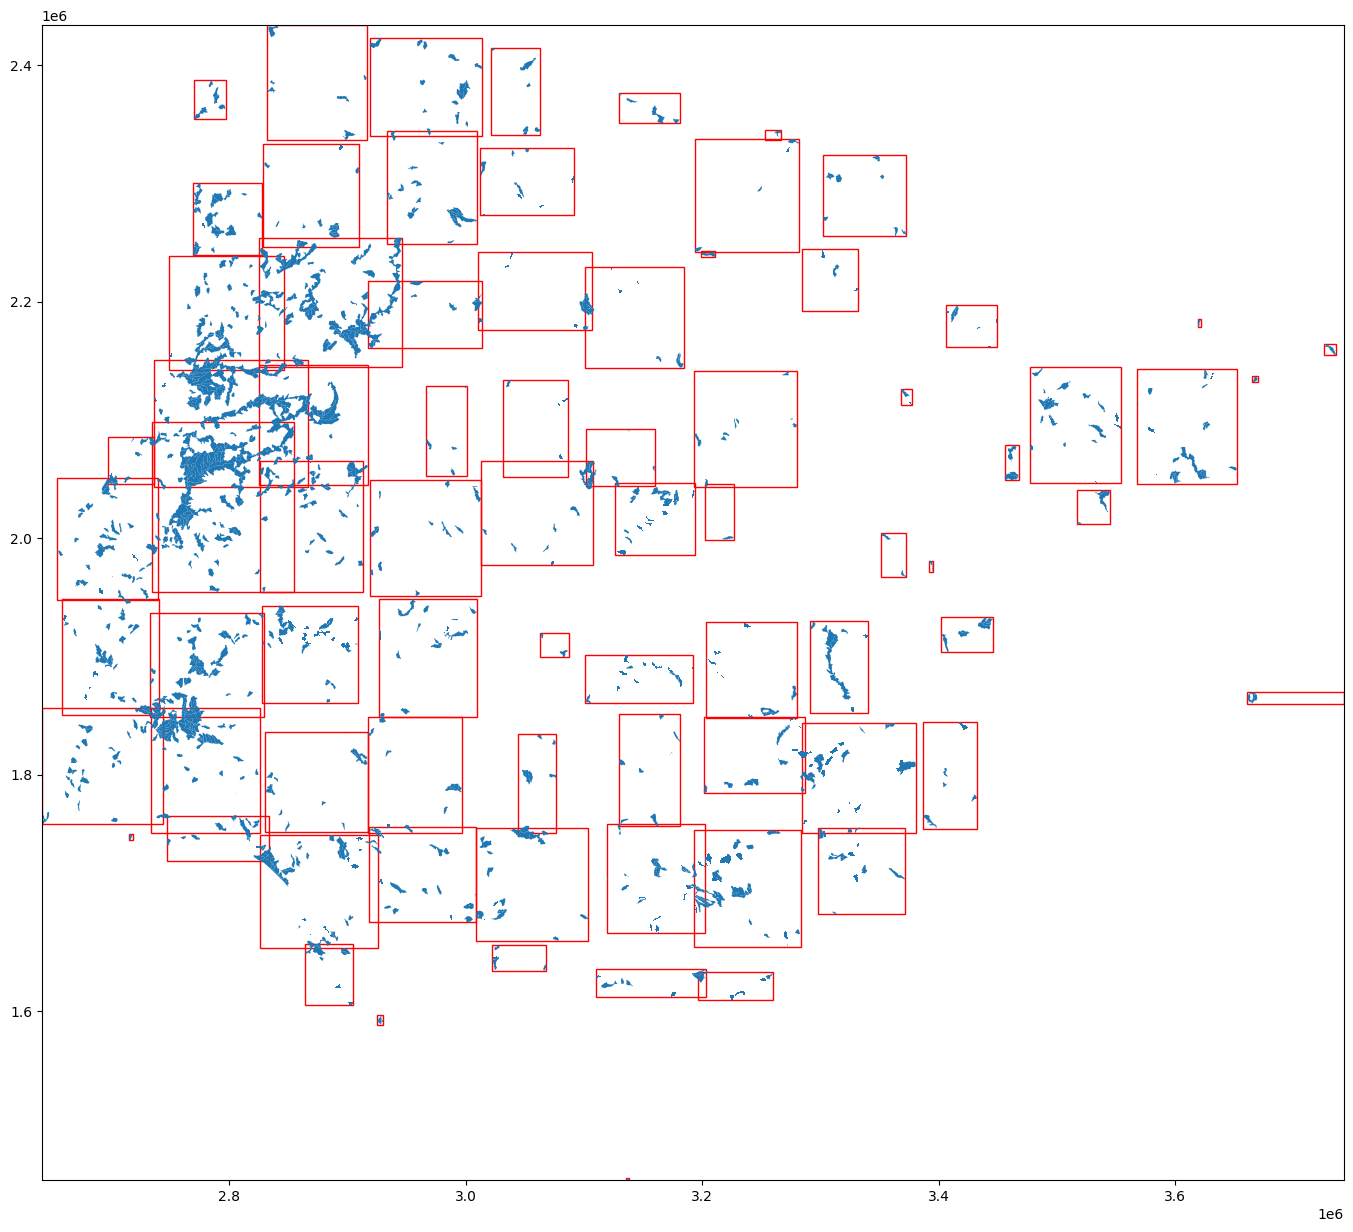

In [17]:


# Define a function to plot bounding boxes
def plot_bounding_boxes(basins, ax):
  # Get the bounds of the selected area
  minx, miny, maxx, maxy = basins.total_bounds
  rect = plt.Rectangle((minx, miny), (maxx - minx), (maxy  - miny), edgecolor='r', facecolor='none')
  ax.add_patch(rect)

# Create a plot
fig, ax = plt.subplots(figsize=(20, 15))



# Get the bounds of the selected area
minx, miny, maxx, maxy = IP_Selected_basins.total_bounds

# Calculate the width and height of the bounding box
bbox_width = maxx - minx
bbox_height = maxy - miny

# Calculate the number of columns and rows based on 100 km x 100 km quadrants
num_cols = math.ceil(bbox_width / 100000)
num_rows = math.ceil(bbox_height / 100000)

# Calculate the width and height of each quadrant
quad_width = bbox_width / num_cols
quad_height = bbox_height / num_rows
    # Path to the file
print('Size of the grid:', num_cols, 'cols x', num_rows, 'rows')
print('Total quandrants:', str(num_cols * num_rows ))
# Initialize a set to store the evaluated basin IDs
evaluated_basin_ids = set()
c = 0
for i in range(num_rows):
  for j in range(num_cols):
    xmin = minx + j * quad_width
    xmax = minx + (j + 1) * quad_width
    ymin = miny + i * quad_height
    ymax = miny + (i + 1) * quad_height

    #quad_bbox = tuple(xmin, ymin, xmax, ymax)
    quad_basins = IP_Selected_basins.iloc[IP_Selected_basins.sindex.query(shapely_box(xmin, ymin, xmax, ymax))]
    # Skip this quadrant if there are not basin in it
    if quad_basins.empty:
      continue
      # Filter out already evaluated basins
    quad_basins = quad_basins.loc[~quad_basins['Basin_ID'].isin(evaluated_basin_ids)]
    # Skip this quadrant if basins are already evaluated
    if quad_basins.empty:
      continue
    if len(quad_basins) > 0:
      c= c+1
      plot_bounding_boxes(quad_basins, ax)
      # Add evaluated basin IDs to the set
      evaluated_basin_ids.update(quad_basins['Basin_ID'])
      quad_with_basin = quad_basins
print('Quandrants with basins:', str(c))
IP_Selected_basins.plot(ax=ax)
# Set plot limits
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Show the plot
plt.show()

## Estimate the average CN number for each basin in 2012 and 2018

### Function to crop and vectorise the reclassified slope raster map for each basins group (quad basins)

In [18]:
from rasterio.mask import mask as ras_mask
from shapely.geometry import shape


# Function to clip raster to basin extent and vectorize
def clip_and_vectorize_raster(basins_geom, raster_path, nodata_val):
    opath = 'clipped_raster.tif'

    # Read the raster
    with rasterio.open(raster_path) as mdt_zona:
        # Use the shape basins as mask
        out_image, out_transform = ras_mask(mdt_zona, basins_geom, all_touched=True, nodata=nodata_val, crop=True)

        # Copy metadata
        out_meta = mdt_zona.meta.copy()

    # Update metadata
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})
    # Create a .tif file with the raster cut out
    with rasterio.open(opath, "w", **out_meta) as mdt_qnk:
        mdt_qnk.write(out_image)
    # Close
    mdt_zona.close()
    mdt_qnk.close()

    # Import the clipped raster
    raster_src = rasterio.open(opath)
    # Read raster data
    raster_data = raster_src.read(1)
    mask_basin = raster_data != nodata_val
    # Generate shapes from the raster data
    vector_features = list(rasterio.features.shapes(raster_data, mask=mask_basin, connectivity=8, transform=raster_src.transform))
    # Create a GeoDataFrame
    basin_gdf= gpd.GeoDataFrame(({'geometry': [shape(geometry) for geometry, value in vector_features], 'value': [value for geometry, value in vector_features]}), crs=basins_geom.crs)

    #  Close
    raster_src.close()

    # Check if the file exists before attempting to delete it
    if os.path.exists(opath):
      # Delete the file
      os.remove(opath )
      #print(f"File '{opath }' deleted successfully.")
    else:
      pass
      #print(f"File '{opath }' does not exist.")


    return basin_gdf

In [19]:
def get_slope(basins, slope_reclass_path, no_data=-9999):
  slope_reclass_vec= clip_and_vectorize_raster(basins.geometry, slope_reclass_path, no_data)
  # Change the data type of the Corine code (from float to integer)
  slope_reclass_vec.loc[:,'Slope_digits'] = slope_reclass_vec.loc[:,'value'].astype(int)
  #slope_reclass_vec.loc[:,'Code_reclass_slp'] = slope_reclass_vec.loc[:,'Slope_digits'].astype(str)
  ### drop value column ###
  slope_reclass_vec = slope_reclass_vec.drop('value', axis=1)
  return slope_reclass_vec

In [20]:
slope_reclass_path = '/content/drive/MyDrive/Iberia_project/03_Results/slope_reclass.tif'
slope_reclass_vec =  get_slope(quad_with_basin, slope_reclass_path, no_data=-9999)
slope_reclass_vec

,geometry,Slope_digits
0,"POLYGON ((3262478.016 2343935.080, 3262478.016...",1000
1,"POLYGON ((3262635.491 2343856.343, 3262635.491...",1000
2,"POLYGON ((3262478.016 2343777.605, 3262478.016...",1000
3,"POLYGON ((3261611.907 2343620.131, 3261611.907...",2000
4,"POLYGON ((3261769.381 2343462.656, 3261769.381...",2000
5,"POLYGON ((3262871.702 2342754.021, 3262871.702...",2000
6,"POLYGON ((3265076.345 2342754.021, 3265076.345...",1000
7,"POLYGON ((3261060.746 2342517.810, 3261060.746...",2000
8,"POLYGON ((3265627.505 2342517.810, 3265627.505...",1000
9,"POLYGON ((3264367.710 2342360.335, 3264367.710...",1000


<Axes: >

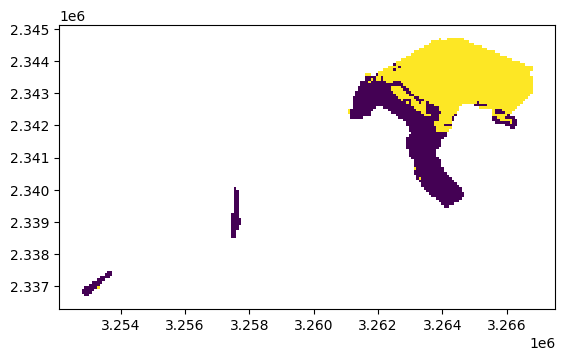

In [21]:
slope_reclass_vec.plot(column='Slope_digits')

### Location of the quad basins in the Iberian Peninsula

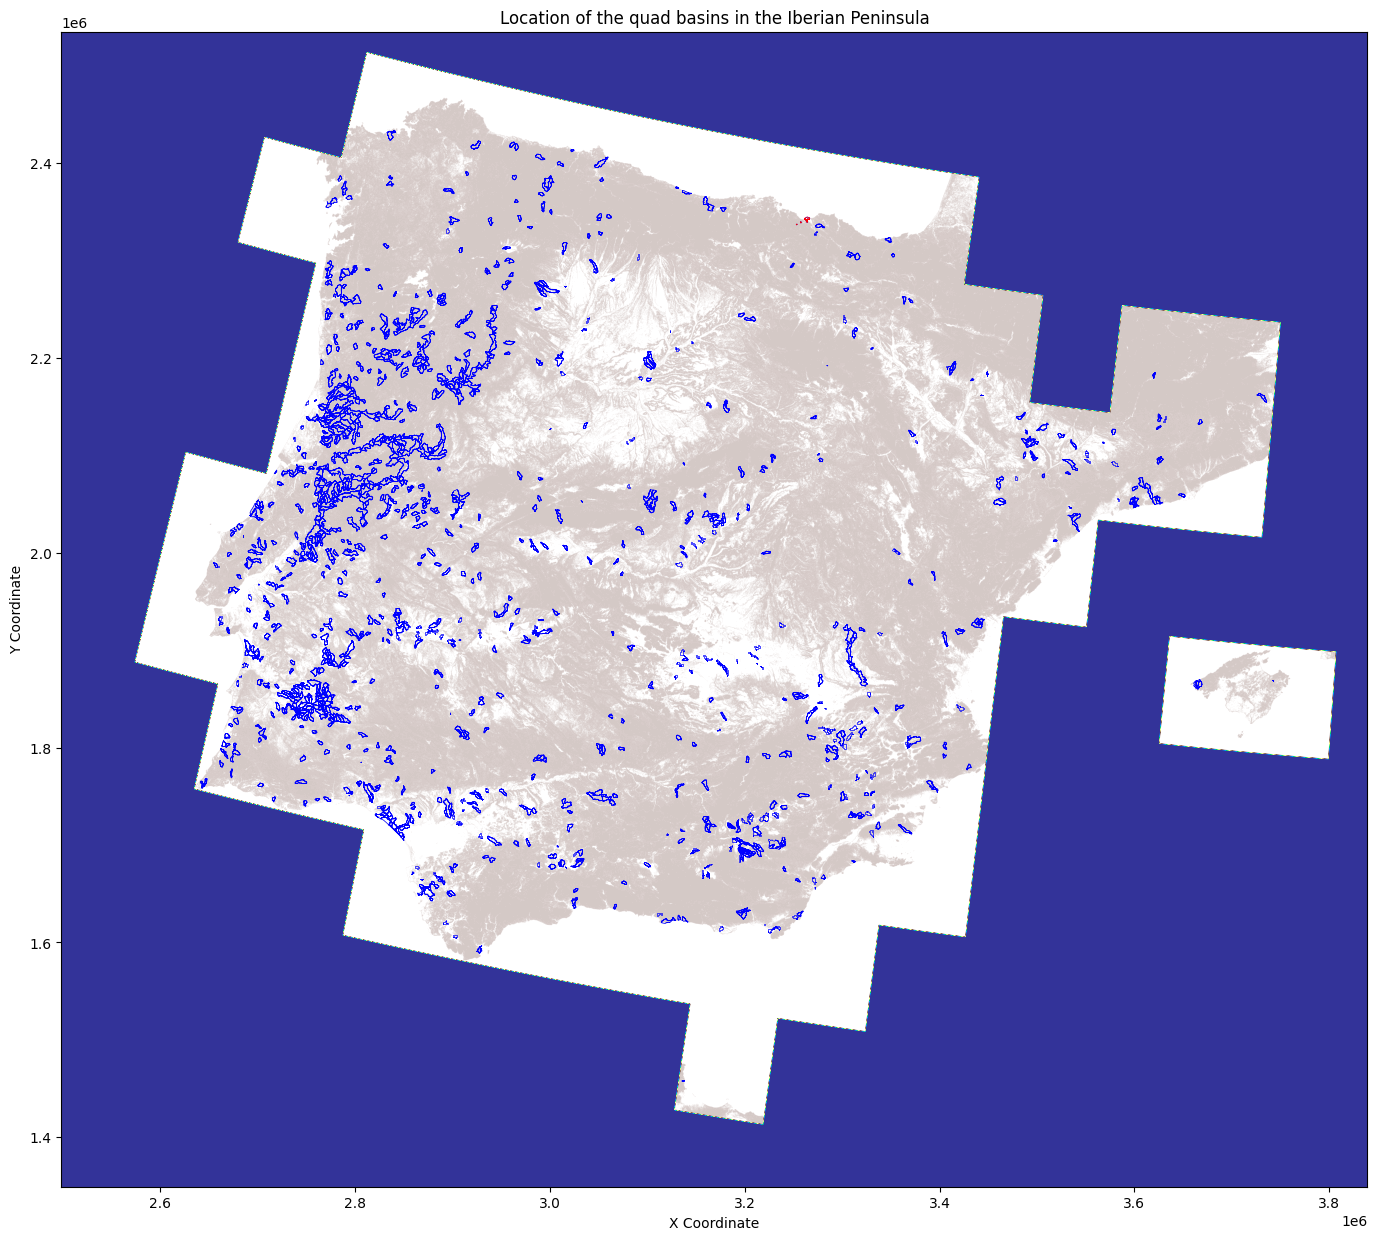

In [22]:
# Open the raster file
with rasterio.open("/content/drive/MyDrive/Iberia_project/03_Results/slope_reclass.tif") as src:
    # Read the raster data
    raster_data = src.read(1)  # Assuming you're reading the first band

    # Get the raster extent
    left, bottom, right, top = src.bounds

# Create a plot and plot raster data
    fig, ax = plt.subplots(figsize=(20, 15))
    rasplot.show(raster_data, cmap='terrain', extent=(left, right, bottom, top), ax=ax)

# Plot GeoDataFrames

    IP_Selected_basins.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.5)
    quad_with_basin.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Location of the quad basins in the Iberian Peninsula')
    plt.show()

### Function to create the hydrological soil group map for each basins group (quad basins)

In [23]:
import shutil

def get_Hydro_soil_group(basins, crs_epgs):
  # Reproject to the spatial reference system used by the Soilgrids maps.
  wkt_string = (
      'PROJCS["Homolosine", '
      'GEOGCS["WGS 84", '
      'DATUM["WGS_1984", '
      'SPHEROID["WGS 84",6378137,298.257223563, '
      'AUTHORITY["EPSG","7030"]], '
      'AUTHORITY["EPSG","6326"]], '
      'PRIMEM["Greenwich",0, '
      'AUTHORITY["EPSG","8901"]], '
      'UNIT["degree",0.0174532925199433, '
      'AUTHORITY["EPSG","9122"]], '
      'AUTHORITY["EPSG","4326"]], '
      'PROJECTION["Interrupted_Goode_Homolosine"], '
      'UNIT["Meter",1]]'
  )
  crs_soils = pyproj.CRS.from_string(wkt_string)
  qnk_holo = basins.to_crs(crs_soils)

  # The minimum and maximum basin coordinates are extracted.
  qnk_coords = qnk_holo['geometry']
  qnk_coords = qnk_coords.total_bounds

  # Define the clipping extension
  exten = [('X', qnk_coords[0] - 1000, qnk_coords[2] + 1000), ('Y', qnk_coords[1] - 10000, qnk_coords[3] + 1000)]
  # Define the CRS in which the information will be downloaded.
  crs_V2 = "http://www.opengis.net/def/crs/EPSG/0/152160"# CRSs refers to the opengis.net registry.

  # Create a directory to store the downloaded information
  !mkdir soils
  # Download the layers up to 1 m
  capas = ['clay', 'sand', 'silt']
  file_names = []
  for capa in capas:
      wcs_path = ''.join(['https://maps.isric.org/mapserv?map=/map/', capa,'.map'])
      wcs = WebCoverageService(wcs_path, version='2.0.1')
      names = [k for k in wcs.contents.keys() if k.endswith("mean")]
      i = 0
      for name in names[0:-1]:
          c_metadata = wcs.contents[name]
          response = wcs.getCoverage(identifier=[name], crs=crs_V2, subsets=exten, resx=250, resy=250, format=c_metadata.supportedFormats[0])
          file_name = ''.join([name, '.tif'])
          file_path = ''.join(['./soils/',file_name])
          with open(opj(file_path), 'wb') as file:
              file.write(response.read())
          file_names.append(file_name)
          #print(''.join([file_name, ' has been successfully downloaded']))

  # Weighted average for each layer according to its depth.
  # The variables needed to read and operate the raster are initialised.
  file_path = ''.join(['./soils/', file_names[-1]])
  silt_ras= rasterio.open(opj(file_path), driver="GTiff")
  silt_num = silt_ras.read(1)
  ipath = "./soils/"
  peso = [5, 10, 15, 30, 40]
  k_clay = 0
  k_sand = 0
  k_silt = 0
  clay = np.zeros(silt_num.shape)
  sand = np.zeros(silt_num.shape)
  silt = np.zeros(silt_num.shape)
  # We make a loop that operates all the raster we have downloaded in the soils folder.
  for file_name in file_names:
      #print(file_name) # Print to verify the order of execution
      if file_name.startswith('clay'):
          capa_path = ''.join([ipath, file_name])
          capa_ras = rasterio.open(opj(capa_path), driver="GTiff")
          clay = clay + capa_ras.read(1) * peso[k_clay] / 1000
          k_clay = k_clay + 1
      elif file_name.startswith('sand'):
          capa_path = ''.join([ipath, file_name])
          capa_ras = rasterio.open(opj(capa_path), driver="GTiff")
          sand = sand + capa_ras.read(1) * peso[k_sand] / 1000
          k_sand = k_sand + 1
      elif file_name.startswith('silt'):
          capa_path = ''.join([ipath, file_name])
          capa_ras = rasterio.open(opj(capa_path), driver="GTiff")
          silt = silt + capa_ras.read(1) * peso[k_silt] / 1000
          k_silt = k_silt + 1
  # We print to check
  #suma = clay + sand + silt
  #print(suma.max())
  #print(suma.min())

  ### Classify soils according to their average clay, sand and silt content
  # We create an array with the values assigned to each classification.
  no_data_value = 0
  texture = np.zeros(clay.shape)
  texture[(clay >= 55) & (sand <= 45) & (silt < 40)] = 1 # Clay
  texture[(clay >= 27) & (clay < 40) & (sand > 20) & (sand <= 45)] = 2 #  Clay loam
  texture[(clay >= 7) & (clay < 27) & (silt >= 28) & (silt < 50) & (sand < 52)] = 3 # Loam
  texture[((silt + 1.5 * clay) >= 15) & ((silt + 2* clay) < 30)] = 4 # Loamy sand
  texture[((silt + 1.5 * clay) < 15)] = 5 # Sand
  texture[(clay >= 35 )& (sand > 45)] = 6  # Sandy clay
  texture[(clay >= 20) & (clay < 35) & (silt < 28) & (sand > 45)] = 7 # Sandy clay loam
  texture[((clay >= 7) & (clay < 20) & (sand > 52) & ((silt+2*clay) >= 30)) | ((clay < 7) & (silt < 50) & ((silt+2*clay >= 30)))] = 8 # Sandy loam
  texture[(silt >= 80) & (clay < 12)] = 9 # Silt
  texture[(clay >= 40) & (silt >= 40)] = 10 # Silty clay
  texture[(clay >= 27) & (clay < 40) & (sand <= 20)] = 11 # Silty clay loam
  texture[((silt >= 50) & (clay >= 12) & (clay < 27)) | ((silt >= 50) & (silt < 80) & (clay < 12))] = 12 # Silt loam
  texture[(sand == no_data_value) | (silt == no_data_value) | (clay == no_data_value)] = 0 # NO DATA / Water surface

  # The variables needed to read and operate the raster are initialised.
  opath = "./soils/USDAtextures.tif"
  ipath = "./soils/clay_0-5cm_mean.tif"

  with rasterio.open(opj(ipath)) as src:
      metadata =  src.meta.copy()
  with rasterio.open(opath, 'w', **metadata) as dst:
      # Write the data to the new GeoTIFF file
      dst.write(texture, 1)
  src.close()
  dst.close()
  #print(''.join(['File created: ', opath]))

  # We create an array with the hydrological groups of the soil according to texture.
  g_hidro = np.zeros(texture.shape)
  g_hidro[(texture == 5) | (texture == 4)] = 1 # A
  g_hidro[(texture == 7) | (texture == 8) | (texture == 3) | (texture == 12)] = 2 # B
  g_hidro[(texture == 6) | (texture == 2) | (texture == 11) | (texture == 9)] = 3 # C
  g_hidro[(texture == 1) | (texture == 10)] = 4 # D
  g_hidro[(texture == 0)] = 0 # D / Water

  # The variables needed to read and operate the raster are initialised.
  opath = "./soils/groups_hydro.tif"
  ipath = "./soils/clay_0-5cm_mean.tif"
  with rasterio.open(opj(ipath)) as src:
      metadata =  src.meta.copy()
  with rasterio.open(opath, 'w', **metadata) as dst:
      # Write the data to the new GeoTIFF file
      dst.write(g_hidro, 1)
  src.close()
  dst.close()
  #print(''.join(['File created: ', opath]))

  from rasterio.warp import calculate_default_transform, reproject, Resampling

  dst_crs = crs_epgs

  with rasterio.open("./soils/groups_hydro.tif") as src:
      transform, width, height = calculate_default_transform(
          src.crs, dst_crs, src.width, src.height, *src.bounds)
      kwargs = src.meta.copy()
      kwargs.update({
          'crs': dst_crs,
          'transform': transform,
          'width': width,
          'height': height
      })

      with rasterio.open('./soils/groups_hydro_reprojected.tif', 'w', **kwargs) as dst:
          for i in range(1, src.count + 1):
              reproject(
                  source=rasterio.band(src, i),
                  destination=rasterio.band(dst, i),
                  src_transform=src.transform,
                  src_crs=src.crs,
                  dst_transform=transform,
                  dst_crs=dst_crs,
                  resampling=Resampling.nearest)

  # Hydrologic soil group
  HSG_vec = clip_and_vectorize_raster(basins.geometry, './soils/groups_hydro_reprojected.tif', -1)
  # Change the data type
  HSG_vec.loc[:,'HGS_digits'] = HSG_vec.loc[:,'value'].astype(int)
  HSG_vec.loc[:,'HGS_digits'] = HSG_vec.loc[:,'HGS_digits'] * 10000;
  #HSG_vec.loc[:,'Code_HGS'] = HSG_vec.loc[:,'HGS_digits'].astype(str)
  ### drop value column ###
  HSG_vec = HSG_vec.drop('value', axis=1)
  # Delete files and variables
  del g_hidro, texture, silt, sand, clay, silt_ras
  os.remove('./soils/groups_hydro_reprojected.tif')
  os.remove('./soils/groups_hydro.tif')
  os.remove('./soils/USDAtextures.tif')
  # Delete the soils/ directory
  shutil.rmtree('./soils/')
  return HSG_vec




In [24]:
HSG_vec = get_Hydro_soil_group(quad_with_basin, 'EPSG:3035')
HSG_vec

,geometry,HGS_digits
0,"POLYGON ((3261465.471 2343012.945, 3261465.471...",20000
1,"POLYGON ((3262318.787 2342728.506, 3262318.787...",30000
2,"POLYGON ((3261465.471 2343297.383, 3261465.471...",30000
3,"POLYGON ((3263456.541 2344719.576, 3263456.541...",0
4,"POLYGON ((3263456.541 2341306.313, 3263456.541...",0
5,"POLYGON ((3262887.664 2342159.629, 3262887.664...",30000
6,"POLYGON ((3263740.980 2340452.997, 3263740.980...",20000
7,"POLYGON ((3257483.331 2340168.559, 3257483.331...",30000
8,"POLYGON ((3253216.753 2337324.173, 3253216.753...",20000
9,"POLYGON ((3253501.191 2337608.612, 3253501.191...",30000


<Axes: >

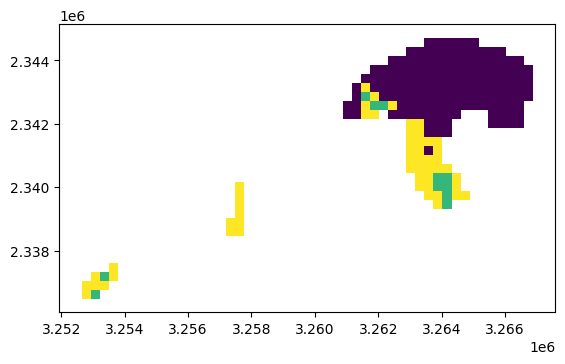

In [25]:
HSG_vec.plot(column='HGS_digits')

### Function to obtain land cover change for each basins group

In [26]:
def get_CLC(basins_gdf, CLC_yyyy_path, CLC_layer, Code_column):
  # Get the bounds of the selected area
  minx, miny, maxx, maxy = basins_gdf.total_bounds
  # Read files using GeoPandas
  quad_CLC_2018 = gpd.read_file(CLC_yyyy_path, layer=CLC_layer, bbox=(minx+1000, miny+1000, maxx+1000, maxy+1000), engine= 'pyogrio', use_arrow=True)
  CLC_2018_basins = basins_gdf.overlay(quad_CLC_2018, how='intersection', keep_geom_type=True, make_valid=True)
  # Change the data type of the Corine code (from string to integer)
  CLC_2018_basins.loc[:,'Corine_digits'] = CLC_2018_basins.loc[:,Code_column].astype(int)
  CLC_2018_basins = CLC_2018_basins.drop([Code_column,'Area_Ha', 'ID', 'Remark'], axis=1)
  return CLC_2018_basins

In [28]:
CLC_2018_path = '/content/temp/CLC/u2018_clc2018_v2020_20u1_geoPackage.zip'
CLC_2018_layer =  'U2018_CLC2018_V2020_20u1'
Code_column = 'Code_18'
CLC_2018_basins = get_CLC(quad_with_basin, CLC_2018_path, CLC_2018_layer, Code_column )
CLC_2018_basins

DataSourceError: '/vsizip//content/temp/CLC/u2018_clc2018_v2020_20u1_geoPackage.zip' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
CLC_2018_path = '/content/u2018_clc2012_v2020_20u1_geoPackage/DATA/U2018_CLC2012_V2020_20u1.gpkg'
CLC_2018_layer =  'U2018_CLC2012_V2020_20u1'
Code_column = 'Code_12'
CLC_2018_basins = get_CLC(quad_with_basin, CLC_2018_path, CLC_2018_layer, Code_column )
CLC_2018_basins

,Basin_ID,geometry,Corine_digits
0,Ebro105576,"MULTIPOLYGON (((3253525.584 2337318.088, 32535...",313
1,Ebro105576,"POLYGON ((3253725.000 2337446.839, 3253725.000...",324
2,Ebro105577,"POLYGON ((3257675.000 2339125.000, 3257725.000...",312
3,Ebro105577,"MULTIPOLYGON (((3257675.000 2339150.000, 32576...",324
4,Ebro100546,"MULTIPOLYGON (((3261384.072 2342250.000, 32613...",121
5,Ebro100546,"POLYGON ((3262083.060 2343468.040, 3262087.070...",121
6,Ebro100546,"POLYGON ((3261266.245 2342524.846, 3261266.920...",321
7,Ebro100546,"POLYGON ((3261200.000 2342242.464, 3261194.765...",331
8,Ebro100546,"POLYGON ((3263949.770 2344642.123, 3263964.419...",123
9,Ebro100546,"MULTIPOLYGON (((3263700.000 2339825.000, 32637...",231


<Axes: >

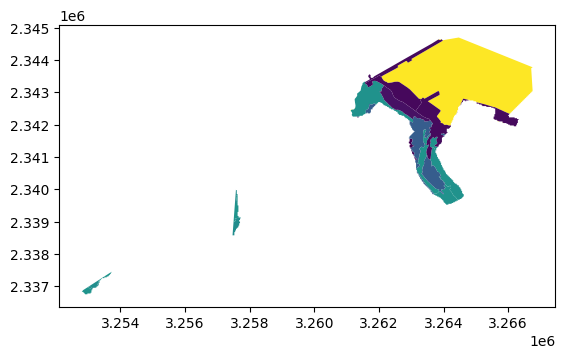

In [ ]:
# Plot quad_CLC_2018
CLC_2018_basins.plot(column='Corine_digits')


### Combine the three maps and estimate the average curve number for each basin in the example basins group

In [ ]:
# Overlay maps
CN_map = CLC_2018_basins.overlay(slope_reclass_vec, how='intersection', keep_geom_type=True, make_valid=True)
CN_map = CN_map.overlay(HSG_vec, how='intersection', keep_geom_type=True, make_valid=True)
CN_map.loc[:,'CN_code'] = CN_map.loc[:,'Corine_digits'] + CN_map.loc[:,'Slope_digits'] + CN_map.loc[:,'HGS_digits']

# Estimate area of each feature
CN_map.loc[:,'Area_Ha'] = CN_map.area / 100000
# Merge the two DataFrames based on the common column
CN_map = CN_map.merge(CN_df[['Code_CN', 'CN']], left_on='CN_code', right_on='Code_CN', how='left')

# Drop the unnecessary columns if needed
CN_map.drop(['Code_CN'], axis=1, inplace=True)

CN_map


,Basin_ID,Corine_digits,Slope_digits,HGS_digits,geometry,CN_code,Area_Ha,CN
0,Ebro105576,324,1000,30000,"MULTIPOLYGON (((3253700.000 2337425.000, 32537...",31324,0.530873,70
1,Ebro105576,312,1000,30000,"MULTIPOLYGON (((3253325.000 2337025.000, 32533...",31312,0.093292,62
2,Ebro105576,313,1000,30000,"MULTIPOLYGON (((3253501.191 2337295.769, 32535...",31313,0.213301,62
3,Ebro105576,312,2000,30000,"POLYGON ((3253275.000 2337000.000, 3253275.000...",32312,0.004408,62
4,Ebro105576,313,2000,30000,"POLYGON ((3253265.761 2337006.204, 3253267.293...",32313,0.000026,62
...,...,...,...,...,...,...,...,...
79,Ebro100546,321,1000,0,"POLYGON ((3263611.910 2341062.990, 3263622.420...",1321,0.293917,85
80,Ebro100546,324,1000,0,"POLYGON ((3263507.030 2341295.550, 3263497.920...",1324,0.068941,76
81,Ebro100546,322,1000,0,"POLYGON ((3263733.770 2341232.580, 3263729.150...",1322,0.036877,76
82,Ebro100546,231,1000,0,"POLYGON ((3263473.950 2341031.440, 3263477.830...",1231,0.008564,80


In [ ]:
print(CLC_2018_basins.crs)
print(slope_reclass_vec.crs)
print(HSG_vec.crs)
print(CN_map.crs)

EPSG:3035
EPSG:3035
EPSG:3035
EPSG:3035


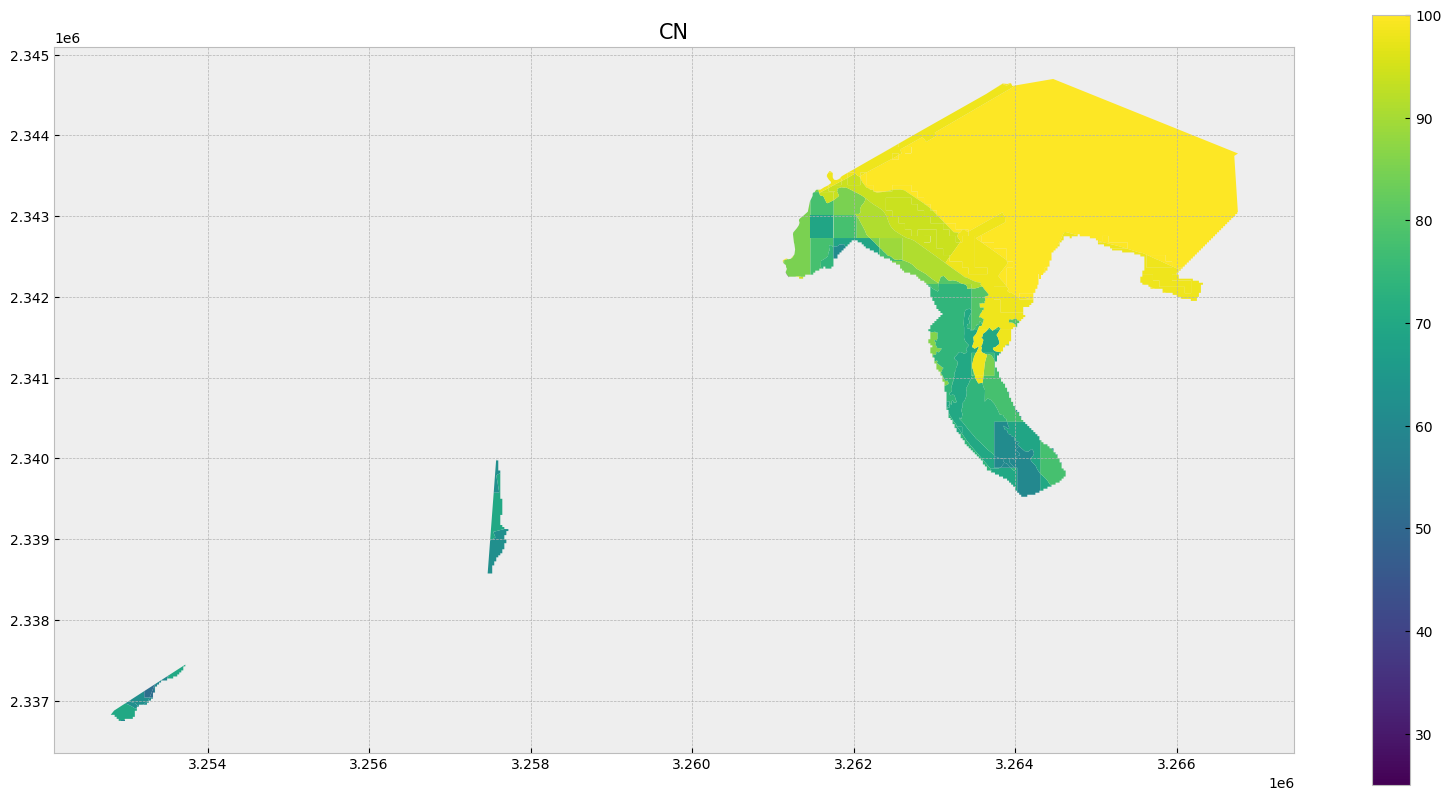

In [ ]:
# Plot to visualise
plt.style.use('bmh') # Estilizamos
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
CN_map.plot(ax=ax, column='CN', cmap='viridis', label='CN', linewidth=0.5, legend = True)
ax.set_title('CN', fontdict = {'fontsize': '15', 'fontweight' : '3'});
# Show the plot
plt.show()

In [ ]:
CN_map['CNxArea'] = CN_map['CN'] * CN_map['Area_Ha']
CN_mean = CN_map.groupby('Basin_ID')['CNxArea'].sum() / CN_map.groupby('Basin_ID')['Area_Ha'].sum()
CN_mean


Basin_ID
Ebro100546    93.248211
Ebro105576    64.664837
Ebro105577    65.537359
dtype: float64

In [ ]:
CN_mean.values

array([93.24821065, 64.66483694, 65.53735897])

Now, define it as function.

In [ ]:
def average_CN(CLC_yyyy_basins, slope_reclass_vec, HSG_vec):
  # Overlay maps
  CN_map = CLC_yyyy_basins.overlay(slope_reclass_vec, how='intersection', keep_geom_type=True, make_valid=True)
  CN_map = CN_map.overlay(HSG_vec, how='intersection', keep_geom_type=True, make_valid=True)
  CN_map.loc[:,'CN_code'] = CN_map.loc[:,'Corine_digits'] + CN_map.loc[:,'Slope_digits'] + CN_map.loc[:,'HGS_digits']

  # Estimate area of each feature
  CN_map.loc[:,'Area_Ha'] = CN_map.area / 100000
  # Merge the two DataFrames based on the common column
  CN_map = CN_map.merge(CN_df[['Code_CN', 'CN']], left_on='CN_code', right_on='Code_CN', how='left')

  # Drop the unnecessary columns if needed
  CN_map.drop(['Code_CN'], axis=1, inplace=True)
  CN_map['CNxArea'] = CN_map['CN'] * CN_map['Area_Ha']
  CN_mean = CN_map.groupby('Basin_ID')['CNxArea'].sum() / CN_map.groupby('Basin_ID')['Area_Ha'].sum()
  return CN_mean



In [ ]:
CN_basins = average_CN(CLC_2018_basins, slope_reclass_vec, HSG_vec)
CN_basins = CN_basins.to_frame(name='CN')
CN_basins

,CN
Basin_ID,
Ebro100546,93.248211
Ebro105576,64.664837
Ebro105577,65.537359


### Run the functions for all basins groups

In [ ]:
# List layers of the Tajo basins geopackage
import fiona
# Path to the file
CLC_2012_path = '/content/u2018_clc2012_v2020_20u1_geoPackage/DATA/U2018_CLC2012_V2020_20u1.gpkg'
# List layers
layers = fiona.listlayers(CLC_2012_path )
# Print
print(layers)

['U2018_CLC2012_V2020_20u1', 'U2018_CLC2012_V2020_20u1_FR_REU', 'U2018_CLC2012_V2020_20u1_FR_GLP', 'U2018_CLC2012_V2020_20u1_FR_GUF', 'U2018_CLC2012_V2020_20u1_FR_MTQ', 'U2018_CLC2012_V2020_20u1_FR_MYT']


In [ ]:
# Get the bounds of the selected area
minx, miny, maxx, maxy = IP_Selected_basins.total_bounds

# Calculate the width and height of the bounding box
bbox_width = maxx - minx
bbox_height = maxy - miny

# Calculate the number of columns and rows based on 100 km x 100 km quadrants
num_cols = math.ceil(bbox_width / 100000)
num_rows = math.ceil(bbox_height / 100000)

# Calculate the width and height of each quadrant
quad_width = bbox_width / num_cols
quad_height = bbox_height / num_rows
    # Path to the file
print('Size of the grid:', num_cols, 'cols x', num_rows, 'rows')
print('Total quandrants:', str(num_cols * num_rows ))
# Initialize a set to store the evaluated basin IDs
evaluated_basin_ids = set()
c = 0
for i in range(num_rows):
  for j in range(num_cols):
    xmin = minx + j * quad_width
    xmax = minx + (j + 1) * quad_width
    ymin = miny + i * quad_height
    ymax = miny + (i + 1) * quad_height

    #quad_bbox = tuple(xmin, ymin, xmax, ymax)
    quad_basins = IP_Selected_basins.iloc[IP_Selected_basins.sindex.query(shapely_box(xmin, ymin, xmax, ymax))]
    # Skip this quadrant if there are not basin in it
    if quad_basins.empty:
      continue
      # Filter out already evaluated basins
    quad_basins = quad_basins.loc[~quad_basins['Basin_ID'].isin(evaluated_basin_ids)]
    # Skip this quadrant if basins are already evaluated
    if quad_basins.empty:
      continue
    if len(quad_basins) > 0:
      c= c+1
      print(c)
      if c < 48:
        continue
      # Add evaluated basin IDs to the set
      evaluated_basin_ids.update(quad_basins['Basin_ID'])
      # Slope
      slope_reclass_path = '/content/drive/MyDrive/Iberia_project/03_Results/slope_reclass.tif'
      slope_reclass_vec =  get_slope(quad_basins, slope_reclass_path, no_data=-9999)

      # Hydrologic soil group
      HSG_vec = get_Hydro_soil_group(quad_basins, 'EPSG:3035')

      # CLC 2012
      CLC_2012_path = '/content/u2018_clc2012_v2020_20u1_geoPackage/DATA/U2018_CLC2012_V2020_20u1.gpkg'
      CLC_2012_layer = 'U2018_CLC2012_V2020_20u1'
      Code_column = 'Code_12'
      CLC_yyyy_basins = get_CLC(quad_basins, CLC_2012_path, CLC_2012_layer, Code_column)
      CN_basins_12 = average_CN(CLC_yyyy_basins, slope_reclass_vec, HSG_vec)
      CN_basins_12 = CN_basins_12.to_frame(name='CN_2012')

      # CLC 2018
      CLC_2018_path = '/content/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg'
      CLC_2018_layer =  'U2018_CLC2018_V2020_20u1'
      Code_column = 'Code_18'
      CLC_yyyy_basins = get_CLC(quad_basins, CLC_2018_path, CLC_2018_layer, Code_column)
      CN_basins_18 = average_CN(CLC_yyyy_basins, slope_reclass_vec, HSG_vec)
      CN_basins_18 = CN_basins_18.to_frame(name='CN_2018')

      # Merge the two DataFrames based on the common column
      IP_Selected_basins.loc[CN_basins_12.index, 'CN_2012'] = CN_basins_12.values
      IP_Selected_basins.loc[CN_basins_18.index, 'CN_2018'] = CN_basins_18.values
print('Quandrants with basins:', str(c))

Size of the grid: 12 cols x 10 rows
Total quandrants: 120
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
mkdir: cannot create directory ‘soils’: File exists
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
Quandrants with basins: 77


Can take like 24 minutes


In [ ]:
IP_Selected_basins

,Basin_ID,geometry,CN_2012,CN_2018
Basin_ID,,,,
Duer100003,Duer100003,"MULTIPOLYGON (((3032153.334 2053840.916, 30321...",65.331639,63.226031
Duer100050,Duer100050,"MULTIPOLYGON (((2765050.000 2198325.000, 27649...",83.234984,83.314941
Duer100194,Duer100194,"MULTIPOLYGON (((2779425.000 2364675.000, 27794...",69.953535,69.264513
Duer100207,Duer100207,"MULTIPOLYGON (((2794300.000 2366775.000, 27941...",65.955587,66.759241
Duer100231,Duer100231,"MULTIPOLYGON (((3136440.595 2371987.346, 31364...",65.911907,67.130929
...,...,...,...,...
Tajo107523,Tajo107523,"MULTIPOLYGON (((2676375.000 2025650.000, 26763...",71.787494,73.368201
Tajo107567,Tajo107567,"MULTIPOLYGON (((3008684.281 2037836.251, 30085...",79.169394,73.231565
Tajo107574,Tajo107574,"MULTIPOLYGON (((2905900.000 2062944.326, 29059...",56.206199,58.859977


In [ ]:
IP_Selected_basins['CN_change'] = IP_Selected_basins['CN_2018'] -IP_Selected_basins['CN_2012']
IP_Selected_basins

,Basin_ID,geometry,CN_2012,CN_2018,CN_change
index,,,,,
Duer100003,Duer100003,"MULTIPOLYGON (((3032153.334 2053840.916, 30321...",65.331639,63.226031,-2.105608
Duer100050,Duer100050,"MULTIPOLYGON (((2765050.000 2198325.000, 27649...",83.234984,83.314941,0.079956
Duer100194,Duer100194,"MULTIPOLYGON (((2779425.000 2364675.000, 27794...",69.953535,69.264513,-0.689023
Duer100207,Duer100207,"MULTIPOLYGON (((2794300.000 2366775.000, 27941...",65.955587,66.759241,0.803654
Duer100231,Duer100231,"MULTIPOLYGON (((3136440.595 2371987.346, 31364...",65.911907,67.130929,1.219022
...,...,...,...,...,...
Tajo107523,Tajo107523,"MULTIPOLYGON (((2676375.000 2025650.000, 26763...",71.787494,73.368201,1.580707
Tajo107567,Tajo107567,"MULTIPOLYGON (((3008684.281 2037836.251, 30085...",79.169394,73.231565,-5.937828
Tajo107574,Tajo107574,"MULTIPOLYGON (((2905900.000 2062944.326, 29059...",56.206199,58.859977,2.653778


### Save in Drive

In [ ]:
IP_Selected_basins.to_file("/content/drive/MyDrive/Iberia_project/03_Results/IP_Selected_basins.gpkg", driver="GPKG")

Let's check how many basins hava a CN change bigger than 1

In [ ]:
# write the code line

,Basin_ID,geometry,CN_2012,CN_2018,CN_change
index,,,,,
Duer100231,Duer100231,"MULTIPOLYGON (((3136440.595 2371987.346, 31364...",65.911907,67.130929,1.219022
Duer100540,Duer100540,"MULTIPOLYGON (((2964850.000 2362975.000, 29647...",66.236211,68.565857,2.329645
Duer100605,Duer100605,"MULTIPOLYGON (((2835050.000 2229725.000, 28349...",63.959852,65.999859,2.040007
Duer100788,Duer100788,"MULTIPOLYGON (((2836125.000 2387525.000, 28361...",58.490431,59.581674,1.091243
Duer100831,Duer100831,"MULTIPOLYGON (((2777975.000 2266400.000, 27779...",69.964807,71.78193,1.817123
...,...,...,...,...,...
Tajo107354,Tajo107354,"MULTIPOLYGON (((2737432.484 2119100.000, 27374...",56.546961,58.660259,2.113297
Tajo107358,Tajo107358,"MULTIPOLYGON (((2790150.000 2143175.000, 27901...",61.913953,63.449962,1.536009
Tajo107420,Tajo107420,"MULTIPOLYGON (((3062400.000 1834569.980, 30624...",55.721437,61.860719,6.139281


In [ ]:
# Define a new index or labels
#new_index = range(len(IP_Selected_basins))

# Reindex the GeoDataFrame
#reindexed_gdf = IP_Selected_basins